<a href="https://colab.research.google.com/github/gkadusumilli/3D_pointcloud_classifier/blob/master/3D_object_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D Object detection classifier

[Refer this blog for the detailed instructions](https://https://medium.com/@gkadusumilli/3d-object-classification-in-6-steps-using-kaolin-and-colab-9ecb079143a8) 



In [0]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)
%matplotlib inline

In [0]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


In [0]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [0]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

In [0]:
!pip install git+https://github.com/NVIDIAGameWorks/kaolin.git

  Cloning https://github.com/NVIDIAGameWorks/kaolin.git to /tmp/pip-req-build-htvoimpm
  Running command git clone -q https://github.com/NVIDIAGameWorks/kaolin.git /tmp/pip-req-build-htvoimpm
  Using cached https://files.pythonhosted.org/packages/49/cc/94dd12083678ffbfee7cf5ac8bf341b0e6dac64c422851db094e532d1524/matplotlib-2.2.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/45/af/685bf3ce889ea191f3b916557f5677cc95a5e87b2fa120d74b5dd6d049d0/tqdm-4.32.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6b/d7/c7dbc6377a14f5d98495bd104ec7f1443f654272d23673541d19c3edc8f9/pptk-0.1.0-cp36-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/fd/bbbc569f98f47813c50a116b539d97b3b17a86ac7a309f83b2022d26caf2/Pillow-6.2.2-cp36-cp36m-manylinux1_x86_64.whl
  Created wheel for kaolin: filename=kaolin-0.1.0-cp36-cp36m-linux_x86_64.whl size=19590870 sha256=8162f9d547a3924e3f5f53d4b42ee6305e616d5eb591169f7

In [0]:

import torch
from torch.utils.data import DataLoader
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier
import kaolin.transforms as tfs
from torchvision.transforms import Lambda

In [0]:
modelnet_path = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
print(modelnet_path)
categories = ['chair', 'sofa', 'bed','night_stand']
num_points=1024
device='cuda'
workers = 8

#training parameters
batch_size = 12
learning_rate = 1e-3
epochs = 10



/root/.keras/datasets/ModelNet10


In [0]:
def to_device(inp):
    inp.to(device)
    return inp

transform = tfs.Compose([
    to_device,
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

num_workers = 0 if device == 'cuda' else workers
pin_memory = device != 'cuda'

In [0]:
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform),
                          batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=pin_memory)

In [0]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform),
                        batch_size=batch_size, num_workers=num_workers,
                        pin_memory=pin_memory)

In [0]:
model = PointNetClassifier(num_classes=len(categories)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [0]:

for e in range(epochs):
    print(f'{"":-<10}\nEpoch: {e}\n{"":-<10}')

    train_loss = 0.
    train_accuracy = 0.

    model.train()
    for batch_idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].to(device)
        pred = model(data)
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Train loss:', train_loss / len(train_loader))
    print('Train accuracy:', train_accuracy / len(train_loader))

    val_loss = 0.
    val_accuracy = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].to(device)
            pred = model(data)
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Val loss:', val_loss / len(val_loader))
    print('Val accuracy:', val_accuracy / len(val_loader))

  0%|          | 0/191 [00:00<?, ?it/s]

----------
Epoch: 0
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.8609856279732669
Train accuracy: 0.6592495812795549


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 1.1441759367783864
Val accuracy: 0.565656574612314
----------
Epoch: 1
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.7594486112994049
Train accuracy: 0.7150960030980135


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 0.7864795945810549
Val accuracy: 0.7171717340295966
----------
Epoch: 2
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.6947486830475442
Train accuracy: 0.7526178221115891


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 1.087853354486552
Val accuracy: 0.5530303192861152
----------
Epoch: 3
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.7167065394018333
Train accuracy: 0.732548011223059


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 0.8522190898656845
Val accuracy: 0.6439394095178806
----------
Epoch: 4
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.6535982297665162
Train accuracy: 0.7552356233147426


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 1.0439511528520873
Val accuracy: 0.6565656718431097
----------
Epoch: 5
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.6102796901427014
Train accuracy: 0.7665794254597569


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 1.2768273723847938
Val accuracy: 0.5126262720335614
----------
Epoch: 6
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.6009501860091824
Train accuracy: 0.7796684314755244


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 0.8107051183328484
Val accuracy: 0.6868687028234656
----------
Epoch: 7
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.5515232657262792
Train accuracy: 0.7923211375768272


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 0.5427988835356452
Val accuracy: 0.7929293115933737
----------
Epoch: 8
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.5357202958530156
Train accuracy: 0.8084642431498822


  0%|          | 0/191 [00:00<?, ?it/s]

Val loss: 0.5268328702359488
Val accuracy: 0.7979798136335431
----------
Epoch: 9
----------


  0%|          | 0/33 [00:00<?, ?it/s]

Train loss: 0.5053267929098368
Train accuracy: 0.8219895512645782


100%|██████████| 33/33 [00:33<00:00,  1.02s/it]

Val loss: 0.5521422091758612
Val accuracy: 0.8181818362438318


In [0]:
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                  split='test',transform=transform),
                        shuffle=True, batch_size=15)

data, attr = next(iter(test_loader))
data = data.to('cuda')
labels = attr['category'].to('cuda')
preds = model(data)
pred_labels = torch.max(preds, axis=1)[1]

In [0]:
!git clone 

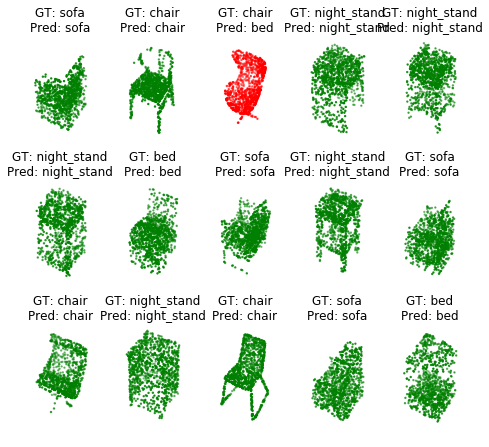

In [0]:

from mpl_toolkits.mplot3d import Axes3D     # unused import necessary to have access to 3d projection # noqa: F401
import matplotlib.pyplot as plt
%matplotlib inline


def visualize_batch(pointclouds, pred_labels, labels, categories):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))

    ncols = 5
    nrows = max(1, batch_size // 5)
    for idx, pc in enumerate(pointclouds):
        label = categories[labels[idx].item()]
        pred = categories[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))

    plt.show()
visualize_batch(data, pred_labels, labels, categories)
